In [35]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
trainData = pd.read_csv('./train.csv')
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [36]:
Cabin = trainData['Cabin'].str[:1]
Cabin[Cabin.isnull()]= 'Nn'
set(Cabin)

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Nn', 'T'}

In [37]:
trainData = trainData.drop('Cabin',axis=1)
trainData = pd.concat([trainData,Cabin],axis=1)
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Nn
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Nn
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Nn


In [38]:
trainData.groupby(Cabin).Survived.value_counts()

Cabin  Survived
A      0             8
       1             7
B      1            35
       0            12
C      1            35
       0            24
D      1            25
       0             8
E      1            24
       0             8
F      1             8
       0             5
G      0             2
       1             2
Nn     0           481
       1           206
T      0             1
dtype: int64

Survived          0      1
Pclass Cabin              
1      A        8.0    7.0
       B       12.0   35.0
       C       24.0   35.0
       D        7.0   22.0
       E        7.0   18.0
       Nn      21.0   19.0
       T        1.0    NaN
2      D        1.0    3.0
       E        1.0    3.0
       F        1.0    7.0
       Nn      94.0   74.0
3      E        NaN    3.0
       F        4.0    1.0
       G        2.0    2.0
       Nn     366.0  113.0

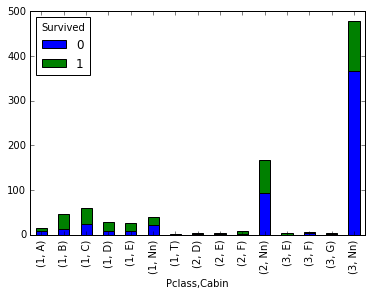

In [39]:
bb=trainData.groupby(['Pclass','Cabin']).Survived.value_counts()
bb.unstack().plot(kind='bar',stacked=True)
bb.unstack()

C:\Users\Saina\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Survived         0     1
Pclass Cabin            
1      A       8.0   7.0
       B      12.0  35.0
       C      24.0  35.0
       D       7.0  22.0
       E       7.0  18.0
       T       1.0   NaN
2      D       1.0   3.0
       E       1.0   3.0
       F       1.0   7.0
3      E       NaN   3.0
       F       4.0   1.0
       G       2.0   2.0

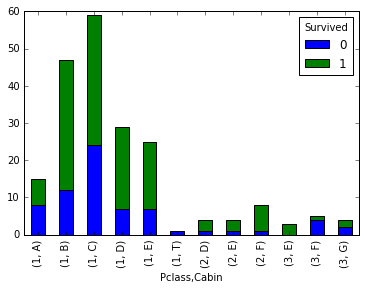

In [43]:
## it seems like that most nan values of Cabin indicates not surving the titanic disaster
trainData.Cabin[(trainData['Cabin']=='Nn')]=np.nan 
bb=trainData.groupby(['Pclass','Cabin']).Survived.value_counts()
bb.unstack().plot(kind='bar',stacked=True)
bb.unstack()

### A and T are only in first Pclass and mainly indicate not surviving
### E presents in all classes and indicate surviving 
### F in class 2 indicates surviving and in class 3 indicates dieing
### For Pclass 3 all Cabin should be changed to Nan to indicate not surviving except for E

In [46]:
### Pclass 3, Cabin E remains and rest will be NaN
### Pclass 1, A and T will be changed to NaN and rest will be E 
### Pclass 2, all Cabins to E rest will be NaN

CabE = pd.DataFrame(np.NaN, index=range(len(trainData)), columns=['CabinE'])
CabE[(trainData.Pclass==3)&(trainData.Cabin=='E')]='E'
CabE[(trainData.Pclass==2)&((trainData.Cabin=='D')|(trainData.Cabin=='E')|(trainData.Cabin=='F'))]='E'
CabE[(trainData.Pclass==1)&((trainData.Cabin=='B')|(trainData.Cabin=='C')|
                            (trainData.Cabin=='D')|(trainData.Cabin=='E'))]='E'
trainData = pd.concat([trainData,CabE],axis=1)

,Survived,0,1
Pclass,CabinE,,
1,E,50.0,110.0
2,E,3.0,13.0
3,E,NaN,3.0


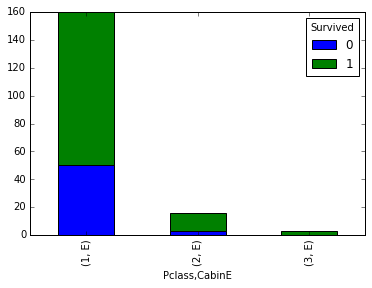

In [57]:
bb=trainData.groupby(['Pclass','CabinE']).Survived.value_counts()
bb.unstack().plot(kind='bar',stacked=True)
bb.unstack()

In [59]:
### skewed fare distribution transformation, log should be applied
fare = pd.DataFrame(np.nan, index=range(len(trainData)), columns=['FarePer'])
fare.FarePer = trainData.Fare
for ii in xrange(len(trainData)):
    if ((trainData.Fare[ii]>0) & ((trainData.SibSp[ii]+trainData.Parch[ii])>0)):
        fare.FarePer[ii] = (trainData.Fare[ii]*1.00)/(trainData.SibSp[ii]+trainData.Parch[ii]+1)
max(fare['FarePer'])

512.32920000000001

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


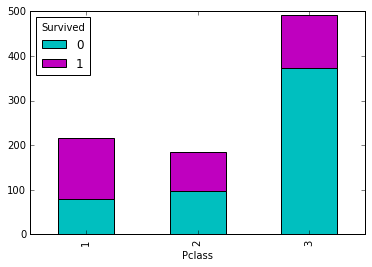

In [49]:
## more likely to survive if among class1 and even 2
b=trainData.groupby('Pclass').Survived.value_counts()
b.unstack().plot(kind='bar',stacked=True,color=['c','m'])
b.unstack()

In [60]:
#### see if the fare price had anything to do with surviving
trainData = pd.concat([trainData,fare],axis=1)
c=trainData[['FarePer','Survived']].groupby('Survived')
pd.isnull(c)
c.describe()
### if there was a nan values then... .dropna().groupby...

FarePer  Survived
Survived                            
0        count  549.000000     549.0
         mean    13.651162       0.0
         std     18.918880       0.0
         min      0.000000       0.0
         25%      7.226400       0.0
         50%      7.925000       0.0
         75%     13.000000       0.0
         max    227.525000       0.0
1        count  342.000000     342.0
         mean    29.973691       1.0
         std     51.116704       0.0
         min      0.000000       1.0
         25%      7.750000       1.0
         50%     13.000000       1.0
         75%     30.500000       1.0
         max    512.329200       1.0

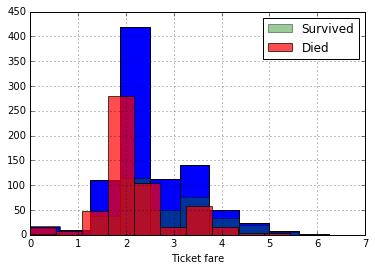

In [75]:
### fare price by survival
logFare = np.log(trainData.FarePer)
logFare[logFare<0]=0
logFare.hist()

c1 = logFare[trainData['Survived']==1]
c2 = logFare[trainData['Survived']==0]

plt.hist(c1, alpha=0.4,label="Survived")
plt.hist(c2, alpha=0.7,label="Died")
plt.legend()
plt.xlabel('Ticket fare')
plt.show()

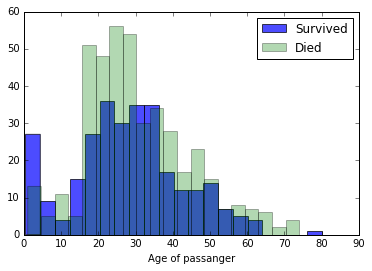

In [18]:
### chances of survival based on age
d = trainData[['Age','Survived']].dropna()
pd.isnull(d)

d1 = d.Age[d['Survived']==1]
d2 = d.Age[d['Survived']==0]

plt.hist(d1.reset_index(drop=True), alpha=0.7,bins=20, label="Survived")
plt.hist(d2.reset_index(drop=True), alpha=0.3, bins=20, label="Died")
plt.legend()
plt.xlabel('Age of passanger')
plt.show()


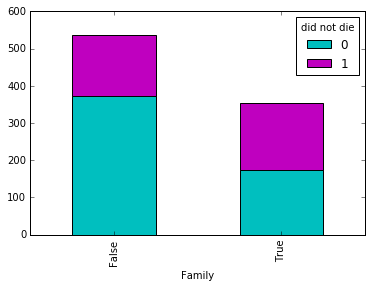

In [19]:
## chances of survival based on having a family member with you
gg=trainData[['SibSp','Parch','Survived']]
gFamily=pd.concat([(gg.SibSp+gg.Parch)>0,y],axis=1)
gFamily.columns=['Family','Survived']   
g1=gFamily.groupby('Family').Survived.value_counts()
g1.unstack().columns.name='did not die'
#g1.keys=['Alone','with family']
g1.unstack().plot(kind='bar',stacked=True,color=['c','m'])

In [20]:
set(X.Embarked)

{nan, 'C', 'Q', 'S'}

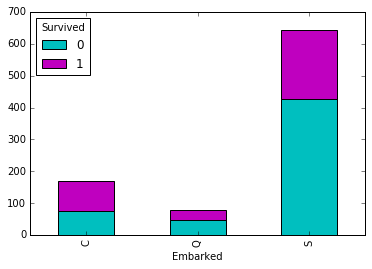

In [21]:
### looking at the number of survival based on the port does not make sense
h = trainData.groupby('Embarked').Survived.value_counts()
h.unstack().plot(kind='bar',stacked=True,color=['c','m'])

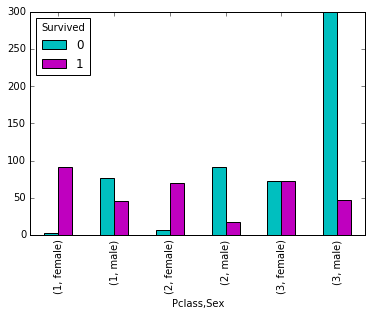

In [11]:
## to me most important features are (1) Sex and (2) social class
dat = trainData.groupby(['Pclass','Sex']).Survived.value_counts()
dat.unstack().plot(kind='bar',color=['c','m'])

In [76]:
## lets group sex as men, women group by shape
## lets assign different size for alone and not alone passanger
## lets signify different classes on X-position

from bokeh.charts import Scatter, output_file, show
from bokeh.models import Range1d

fig = Scatter(trainData, x='Pclass', y='Fare',
                  color='Survived', marker='Sex',
                  title='titanic data',
                  legend=True)

#left, right = 0, 50
#fig.set(x_range=Range1d(left, right))
output_file("titanic_dat.html", title="titanic data")

show(fig)


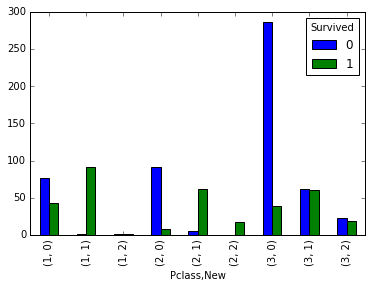

In [77]:
new = pd.DataFrame(0, index=xrange(len(X)), columns=['New']) ## initialize new column

for ii in xrange(len(X)):
    if (X.Age[ii]<10):
        new.New[ii] = 2
    else:
        if (X.Sex[ii]=='female'): 
            new.New[ii]=1
            
data = pd.concat([X.Pclass,new.New,X.Fare,X.Age,trainData.Survived],axis=1)
dat = data.groupby(['Pclass','New']).Survived.value_counts()
dat.unstack().plot(kind='bar')



In [26]:
from bokeh.charts import Scatter, output_file, show
from bokeh.models import Range1d

fig = Scatter(data, x='Pclass', y='Fare',
                  color='Survived', marker='New',
                  title='titanic data',
                  legend=True)

left, right = 0, 300
fig.set(y_range=Range1d(left, right))
output_file("titanic_dat.html", title="titanic data")
show(fig)


[(0, 400)]

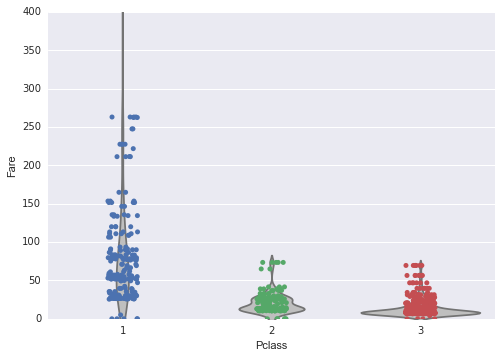

In [27]:
import seaborn as sns

ax = sns.violinplot(x="Pclass", y="Fare", data=data, inner=None, color="0.75")
ax = sns.stripplot(x="Pclass", y="Fare", data=data,jitter=True ) ## jitter widen the data
ax.set(ylim=(0, 400))

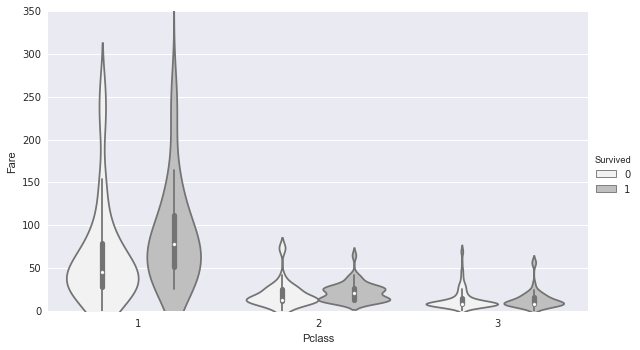

In [28]:
g = sns.factorplot(x="Pclass", y="Fare", hue="Survived", color="0.75",
...                    data=data, kind="violin", size=5, aspect=1.7)
g.set(ylim=(0, 350))

[(0, 300)]

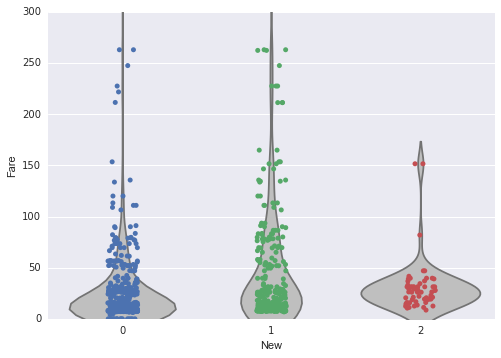

In [29]:
ax = sns.violinplot(x="New", y="Fare", data=data, inner=None, color="0.75")
ax = sns.stripplot(x="New", y="Fare", data=data,jitter=True ) ## jitter widen the data
ax.set(ylim=(0, 300))

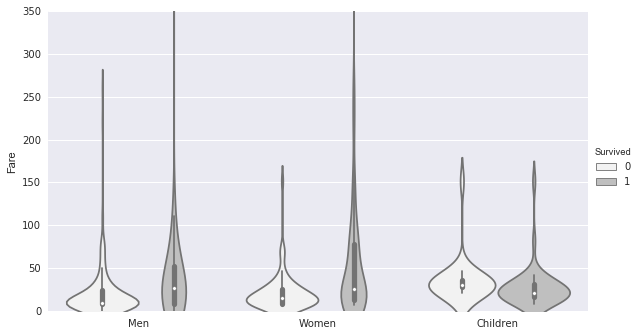

In [30]:
g = sns.factorplot(x="New", y="Fare", hue="Survived", color="0.75",
...                    data=data, kind="violin", size=5, aspect=1.7)
g.set(ylim=(0, 350))
g.set_xticklabels(["Men", "Women", "Children"])
g.set_axis_labels("", "Fare")

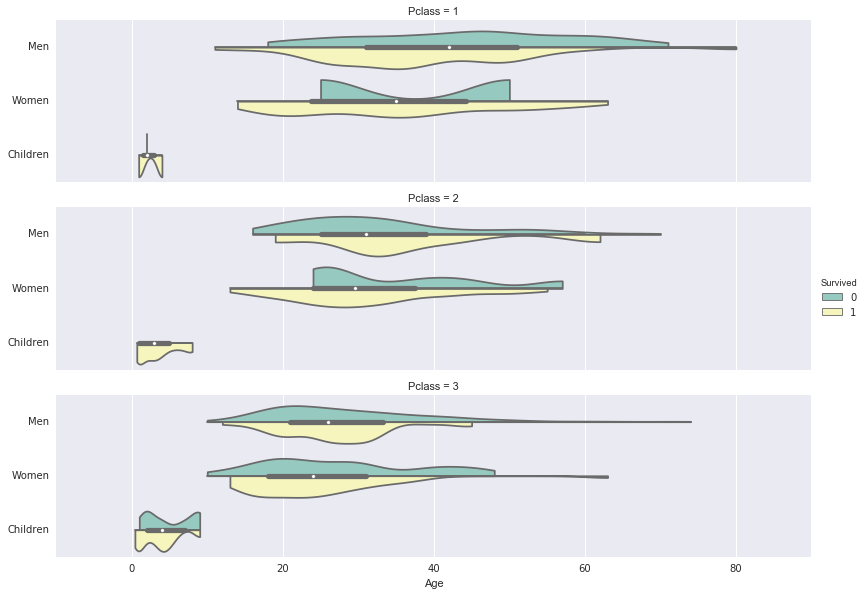

In [31]:
>>> g = sns.factorplot(x="Age", y="New",
...                    hue="Survived", row="Pclass",
...                    data=data,
...                    orient="h", size=2.8, aspect=4.0, palette="Set3",
...                    kind="violin", split=True, cut=0, bw=.3,color="0.75")
#g.set(ylim=(0, 80))
g.set_yticklabels(["Men", "Women", "Children"])
g.set_axis_labels("Age","")

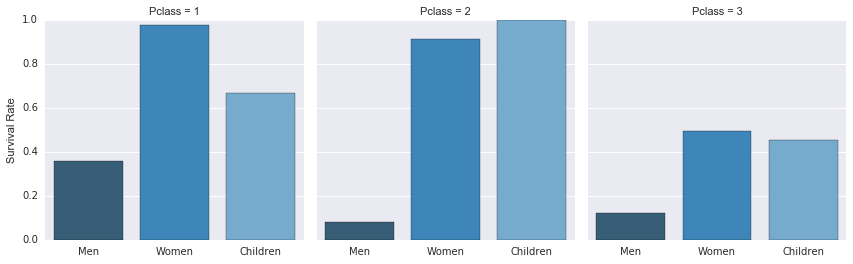

In [32]:
>>> g = sns.factorplot(x="New", y="Survived", col="Pclass",
...          data=data, saturation=.9,kind="bar",ci=None, palette="Blues_d")
>>> (g.set_axis_labels("", "Survival Rate")
...   .set_xticklabels(["Men", "Women", "Children"])
...   .set(ylim=(0, 1))
...   .despine(left=True)) 

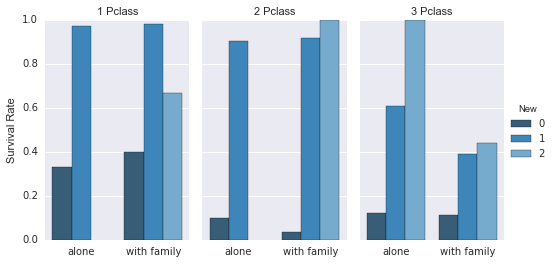

In [33]:
ginger = pd.concat([gFamily,data.Pclass,data.New],axis=1)
>>> g = sns.factorplot(x="Family", y="Survived", col="Pclass",hue="New",
...                    data=ginger, saturation=.9,
...                    kind="bar", ci=None, aspect=.6, palette="Blues_d")
>>> (g.set_axis_labels("", "Survival Rate")
...   .set_xticklabels(["alone", "with family"])
...   .set_titles("{col_name} {col_var}")
...   .set(ylim=(0, 1))
...   .despine(left=True))

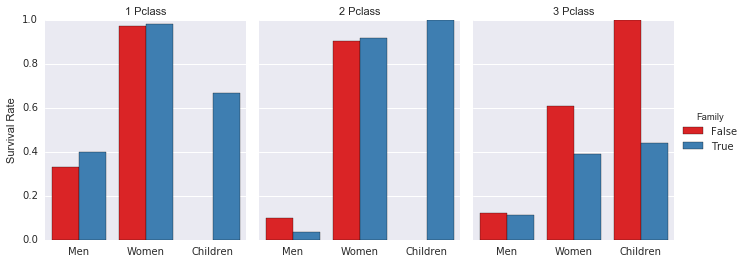

In [34]:
>>> g = sns.factorplot(x="New", y="Survived", col="Pclass",hue="Family",
...                    data=ginger, saturation=.9,
...                    kind="bar", ci=None, aspect=.8, palette="Set1")
>>> (g.set_axis_labels("", "Survival Rate")
...   .set_xticklabels(["Men", "Women","Children"])
...   .set_titles("{col_name} {col_var}")
...   .set(ylim=(0, 1))
...   .despine(left=True))